In [19]:
import requests

In [20]:
country_code = 'CN'
url = f"https://api.openalex.org/sources"
params = {
    'filter': f'country_code:{country_code}',
}
r = requests.get(url, params=params)
num_sources = r.json()['meta']['count']
print(f"There are {num_sources} sources with country_code 'CN' (China)")

There are 1258 sources with country_code 'CN' (China)


In [21]:
params = {
    'filter': f'country_code:{country_code}',
    'group_by': 'type',
}
r = requests.get(url, params=params)
print("Number of sources in China for each *type* of source:")
for item in r.json()['group_by']:
    print(f'  "{item["key"]}": {item["count"]} sources')

Number of sources in China for each *type* of source:
  "journal": 1258 sources


In [22]:
# page through to get all sources
# use paging technique from `paging.ipynb`
# url with a placeholder for page number
country_code = 'CN'
url = f"https://api.openalex.org/sources"
params = {
    'filter': f'country_code:{country_code}',
    'page': 1,  # initaliaze `page` param to 1
}

has_more_pages = True
fewer_than_10k_results = True

# We will collect the data in a variable called `japanese_sources`.
# Initialize this as an empty list, which we will append to
chinese_sources = []

# loop through pages
loop_index = 0
while has_more_pages and fewer_than_10k_results:
    
    page_with_results = requests.get(url, params=params).json()
    
    # loop through partial list of results
    results = page_with_results['results']
    for api_result in results:
        # # Collect the fields we are interested in, for this source
        # source = {field: api_result[field] for field in fields}
        # Append this source to our `japanese_sources` list
        chinese_sources.append(api_result)

    # next page
    params['page'] += 1
    
    # end loop when either there are no more results on the requested page 
    # or the next request would exceed 10,000 results
    per_page = page_with_results['meta']['per_page']
    has_more_pages = len(results) == per_page
    fewer_than_10k_results = per_page * params['page'] <= 10000
    loop_index += 1
print(f"collected {len(chinese_sources)} sources (using {loop_index+1} api calls)")

collected 1258 sources (using 52 api calls)


In [23]:
import pandas as pd

# Each source in our list of `japanese sources` contains a lot of data, some of it complex and nested.
# So let's limit our dataframe to include only some of the fields.

# Define the fields that we are interested in collecting:
fields = [
    'id',
    'issn_l',
    'display_name',
    'host_organization',
    'works_count',
    'cited_by_count',
    'type',
]

# One way to limit the dataframe to include only our `fields` is to use the `from_records()` method
# and specify only the columns we want.
df_sources = pd.DataFrame.from_records(chinese_sources, columns=fields)

num_rows, num_columns = df_sources.shape
print(f"Dataframe has {num_rows} rows and {num_columns} columns.")
print()  # blank line
print("The first five sources are named:")
for name in df_sources['display_name'].head(5):
    print(f"  {name}")

Dataframe has 1258 rows and 7 columns.

The first five sources are named:
  Journal of Anhui Agricultural Sciences
  Anesthesia & Analgesia
  National Medical Journal of China
  Chinese Physics
  Kexue tongbao


In [24]:
df_sources.to_csv("china_sources.csv")

In [25]:
num_host_orgs = df_sources['host_organization'].nunique()
print(f"The Chinese sources are associated with {num_host_orgs} different host organizations (publishers).")

The Chinese sources are associated with 357 different host organizations (publishers).


In [26]:
num_works = df_sources['works_count'].sum()
print(f"There are {num_works:,} works (articles) with Chinese sources.")  # putting ":," after num_works tells the formatter to use commas as thousands separators


There are 2,794,531 works (articles) with Chinese sources.


In [27]:
# Put the data for `counts_by_year` into a Pandas dataframe.
data = []
for source in chinese_sources:
    for year_count in source['counts_by_year']:
        data.append({
            'id': source['id'],
            'year': int(year_count['year']),
            'works_count': int(year_count['works_count']),
            'cited_by_count': int(year_count['cited_by_count']),
        })
df_counts_by_year = pd.DataFrame(data)

# Each row in the dataframe represents one year of one source.
# We can group by year and sum the number of works to get the
# total counts by year.

all_counts_china = df_counts_by_year.groupby('year')['works_count'].sum()
print(f"Created a dataframe counting works from year {all_counts_china.index.min()} to year {all_counts_china.index.max()}.")

Created a dataframe counting works from year 2012 to year 2024.


/Users/oyuesan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of works in Chinese journals')

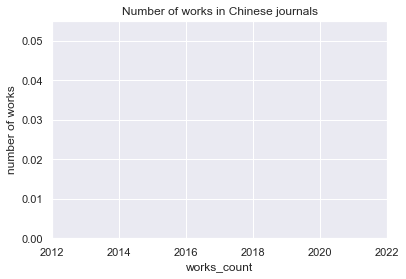

In [28]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

# Visualize the data
g = sns.lineplot(all_counts_china)
g.set_ylim(bottom=0)
g.set_xlim(2012, 2022)
g.set_ylabel("number of works")
g.set_title("Number of works in Chinese journals")

In [29]:
url = f"https://api.openalex.org/works"
filters = [
    'primary_location.source.type:journal',
    'from_publication_date:2012-01-01',
]
params = {
    'filter': ",".join(filters),
    'group_by': 'publication_year',
}
# make the API query
r = requests.get(url, params=params)

# Get the data into a pandas dataframe
counts_data = []
for row in r.json()['group_by']:
    counts_data.append({
        'year': int(row['key']),
        'works_count': int(row['count']),
    })
all_counts_all_countries = pd.DataFrame(counts_data)
# change the data into a series, with the year as index and the number of works as values.
# this will match the `all_counts_japan` data
all_counts_all_countries = all_counts_all_countries.set_index('year')['works_count']

/Users/oyuesan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Relative number of works')

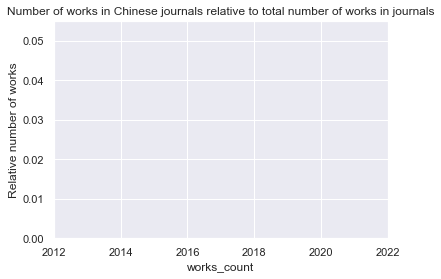

In [30]:
relative_china = all_counts_china / all_counts_all_countries
g = sns.lineplot(relative_china)
g.set_ylim(bottom=0)
g.set_xlim(2012, 2022)
g.set_title("Number of works in Chinese journals relative to total number of works in journals")
g.set_ylabel("Relative number of works")